In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load data
df = pd.read_csv('energy_log.csv')
df.head()

,No,Date,Time,Voltage (V),Current (A),Power (W),Energy (kWh),Frequency (Hz),PF
0,1,1/11/2026,9:12:00,194.4,0.80,77.0,8.69,50.0,0.5
1,2,1/11/2026,9:10:00,192.0,0.84,81.1,8.69,50.0,0.5
2,3,1/11/2026,9:08:00,193.8,0.82,79.2,8.69,50.0,0.5
3,4,1/11/2026,9:06:00,190.3,0.74,70.2,8.68,50.0,0.5
4,5,1/11/2026,9:04:00,193.7,0.79,76.4,8.68,50.0,0.5


In [2]:
df["datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"])

In [3]:
df = df.drop(columns=["Date", "Time", "No"])
df.head()

,Voltage (V),Current (A),Power (W),Energy (kWh),Frequency (Hz),PF,datetime
0,194.4,0.80,77.0,8.69,50.0,0.5,2026-01-11 09:12:00
1,192.0,0.84,81.1,8.69,50.0,0.5,2026-01-11 09:10:00
2,193.8,0.82,79.2,8.69,50.0,0.5,2026-01-11 09:08:00
3,190.3,0.74,70.2,8.68,50.0,0.5,2026-01-11 09:06:00
4,193.7,0.79,76.4,8.68,50.0,0.5,2026-01-11 09:04:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5966 entries, 0 to 5965
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Voltage (V)     5966 non-null   float64       
 1   Current (A)     5966 non-null   float64       
 2   Power (W)       5966 non-null   float64       
 3   Energy (kWh)    5966 non-null   float64       
 4   Frequency (Hz)  5966 non-null   float64       
 5   PF              5966 non-null   float64       
 6   datetime        5966 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 326.4 KB


In [5]:
df.isnull().sum()

Voltage (V)       0
Current (A)       0
Power (W)         0
Energy (kWh)      0
Frequency (Hz)    0
PF                0
datetime          0
dtype: int64

In [6]:
df.describe()

,Voltage (V),Current (A),Power (W),Energy (kWh),Frequency (Hz),PF,datetime
count,5966.000000,5966.000000,5966.000000,5966.000000,5966.000000,5966.000000,5966
mean,195.856202,0.365811,30.046966,5.688027,49.983993,0.400251,2026-01-07 04:18:36.044250624
min,176.400000,0.210000,13.100000,2.450000,49.900000,0.250000,2026-01-02 18:22:00
25%,191.500000,0.260000,17.300000,4.480000,50.000000,0.350000,2026-01-05 02:14:30
50%,195.800000,0.320000,25.200000,5.650000,50.000000,0.400000,2026-01-07 04:47:00
75%,200.400000,0.400000,34.000000,7.027500,50.000000,0.440000,2026-01-09 07:23:30
max,213.200000,2.670000,372.300000,8.690000,50.100000,0.750000,2026-01-11 09:12:00
std,5.906644,0.150957,17.866468,1.693149,0.036944,0.065451,NaN


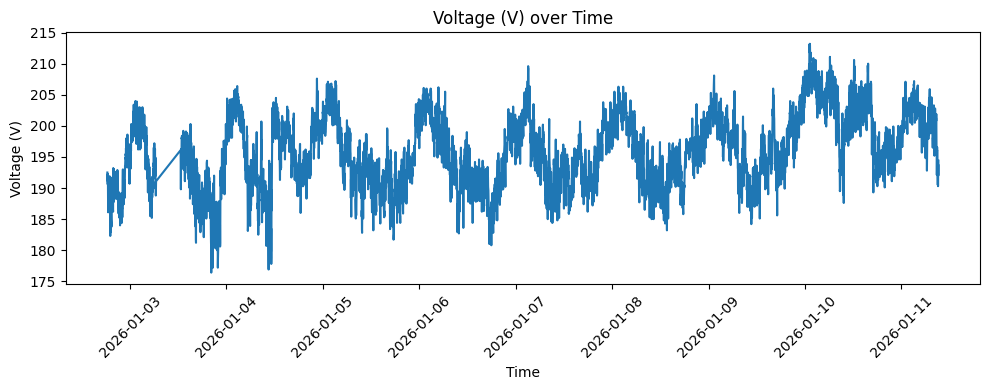

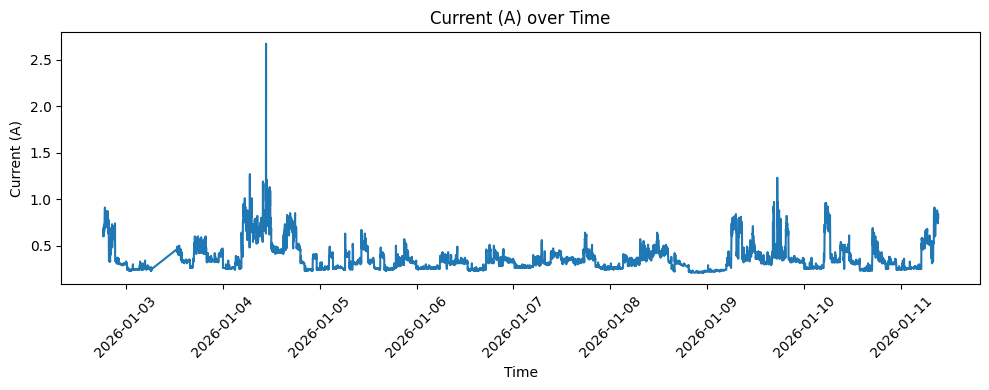

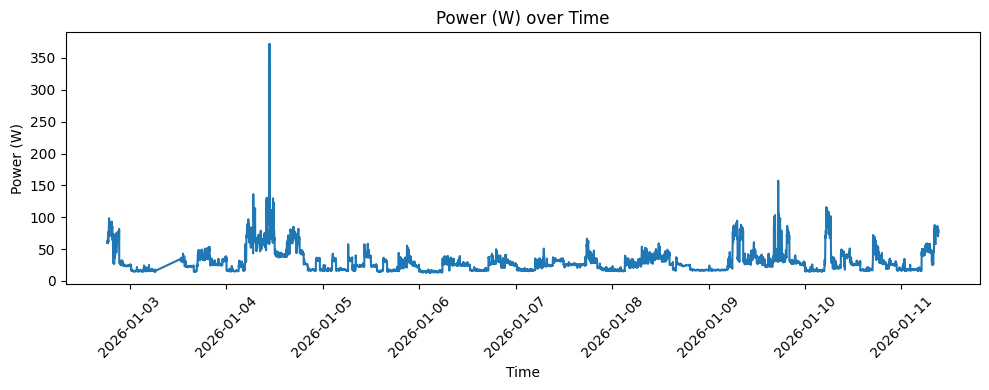

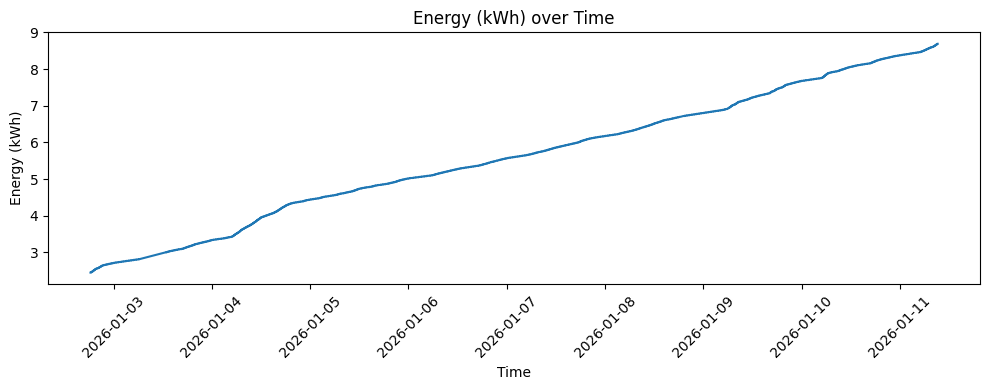

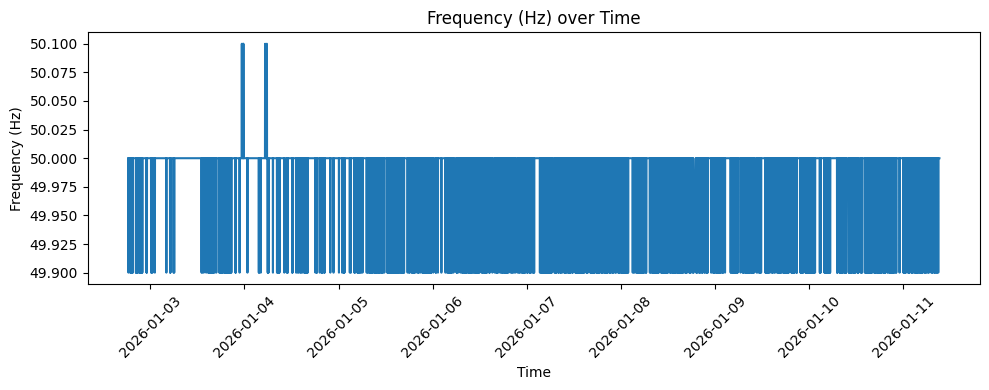

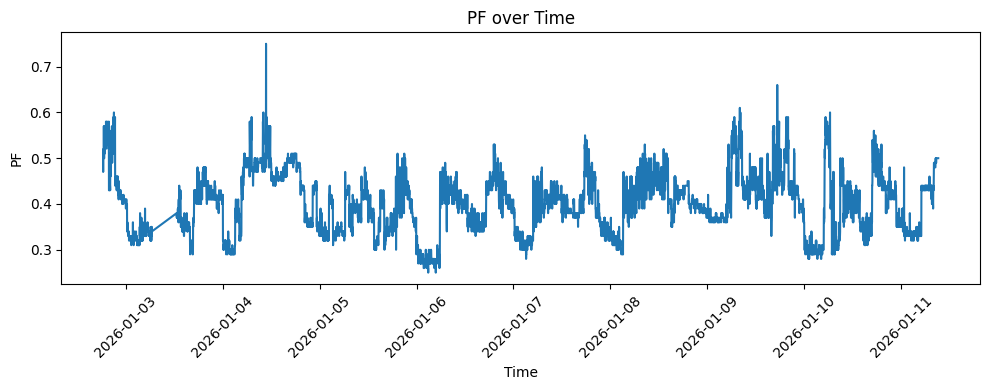

In [7]:
variables = [
    "Voltage (V)",
    "Current (A)",
    "Power (W)",
    "Energy (kWh)",
    "Frequency (Hz)",
    "PF"
]

for var in variables:
    plt.figure(figsize=(10, 4))
    plt.plot(df["datetime"], df[var])
    plt.title(f"{var} over Time")
    plt.xlabel("Time")
    plt.ylabel(var)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

<Figure size 1000x600 with 0 Axes>

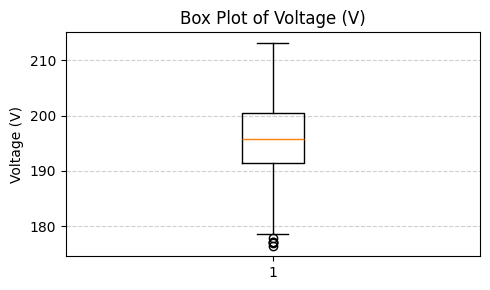

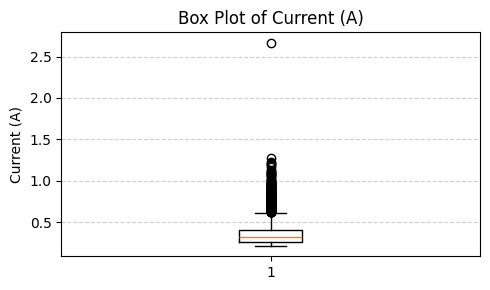

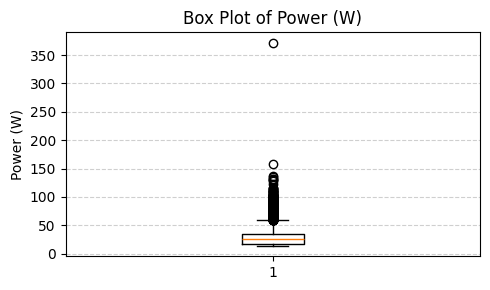

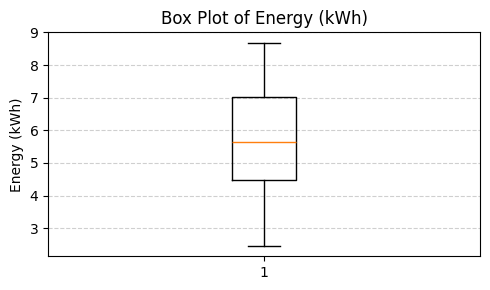

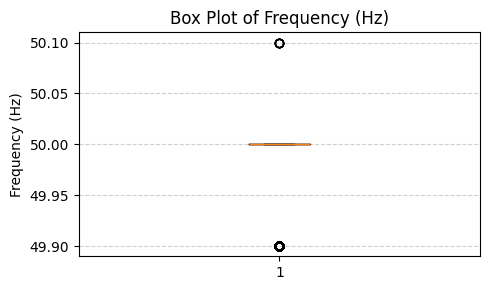

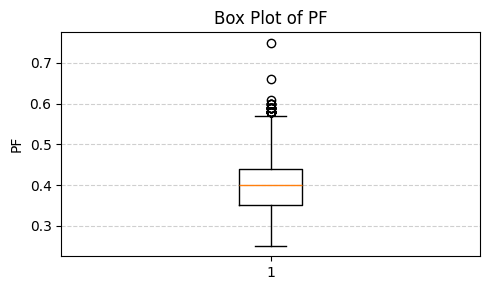

In [8]:
plt.figure(figsize=(10, 6))
for var in variables:
    plt.figure(figsize=(5, 3))
    plt.boxplot(df[var].dropna(), showfliers=True)
    plt.title(f"Box Plot of {var}")
    plt.ylabel(var)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

In [9]:
df = df.sort_values("datetime").reset_index(drop=True)

In [10]:
# ---------- RESAMPLE HOURLY ----------
# Ensure 'datetime' is the index (required for resample)
df = df.set_index("datetime").sort_index()
energy_hourly = df["Energy (kWh)"].resample("1H").last().dropna()

# ---------- AMBIL JAM 00:00 ----------
energy_00 = energy_hourly[energy_hourly.index.hour == 0]

C:\Users\Ahmad Kadafi HS\AppData\Local\Temp\ipykernel_19504\515976177.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  energy_hourly = df["Energy (kWh)"].resample("1H").last().dropna()


In [11]:
# Quick check
print("Index type:", df.index.dtype)
print("First energy_hourly entries:")
print(energy_hourly.head())
print("First energy_00 entries:")
print(energy_00.head())

Index type: datetime64[ns]
First energy_hourly entries:
datetime
2026-01-02 18:00:00    2.49
2026-01-02 19:00:00    2.57
2026-01-02 20:00:00    2.62
2026-01-02 21:00:00    2.66
2026-01-02 22:00:00    2.69
Name: Energy (kWh), dtype: float64
First energy_00 entries:
datetime
2026-01-03    2.73
2026-01-04    3.35
2026-01-05    4.46
2026-01-06    5.03
2026-01-07    5.59
Name: Energy (kWh), dtype: float64


In [12]:
# ---------- BACKTESTING ----------
results = []
dates = energy_00.index

MIN_TRAIN_SIZE = 5   # ⬅️ kunci anti error

for i in range(MIN_TRAIN_SIZE, len(dates)):
    train = energy_00.iloc[:i]
    actual = energy_00.iloc[i]
    actual_date = dates[i]

    try:
        model = SARIMAX(
            train,
            order=(1,1,1),
            seasonal_order=(0,0,0,0),
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        model_fit = model.fit(disp=False)

        pred = float(model_fit.forecast(steps=1).iloc[0])

        results.append({
            "train_until": train.index[-1].date(),
            "predicted_date": actual_date.date(),
            "predicted_energy_kWh": pred,
            "actual_energy_kWh": actual,
            "error_kWh": actual - pred
        })

    except Exception as e:
        # skip jika model gagal
        continue

c:\Users\Ahmad Kadafi HS\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ahmad Kadafi HS\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ahmad Kadafi HS\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ahmad Kadafi HS\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Ahmad Kadaf

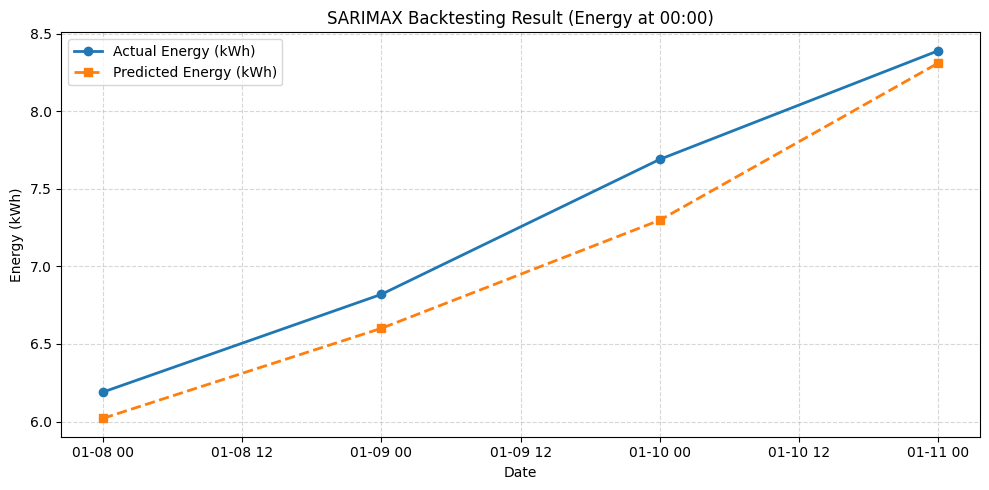

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

eval_df = pd.DataFrame(results)

# ===== JIKA DATA KOSONG =====
if eval_df.empty:
    print("Tidak ada data evaluasi untuk diplot.")
else:
    # ===== PASTIKAN DATETIME =====
    if "predicted_date" in eval_df.columns:
        eval_df["date"] = pd.to_datetime(eval_df["predicted_date"])
    else:
        # fallback aman: train_until + 1 hari
        eval_df["date"] = pd.to_datetime(eval_df["train_until"]) + pd.Timedelta(days=1)

    eval_df = eval_df.sort_values("date")

    # ===== PLOT =====
    plt.figure(figsize=(10,5))

    plt.plot(
        eval_df["date"],
        eval_df["actual_energy_kWh"],
        marker="o",
        linewidth=2,
        label="Actual Energy (kWh)"
    )

    plt.plot(
        eval_df["date"],
        eval_df["predicted_energy_kWh"],
        marker="s",
        linestyle="--",
        linewidth=2,
        label="Predicted Energy (kWh)"
    )

    plt.title("SARIMAX Backtesting Result (Energy at 00:00)")
    plt.xlabel("Date")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [14]:
# ---------- HASIL EVALUASI ----------
eval_df = pd.DataFrame(results)
print(eval_df)

# ---------- METRIK ----------
if not eval_df.empty:
    mae = mean_absolute_error(
        eval_df["actual_energy_kWh"],
        eval_df["predicted_energy_kWh"]
    )

    rmse = mean_squared_error(
        eval_df["actual_energy_kWh"],
        eval_df["predicted_energy_kWh"]
    )

    print("\nMAE :", mae)
    print("RMSE:", rmse)
else:
    print("Data evaluasi tidak cukup.")

  train_until predicted_date  predicted_energy_kWh  actual_energy_kWh  \
0  2026-01-07     2026-01-08              6.020543               6.19   
1  2026-01-08     2026-01-09              6.600930               6.82   
2  2026-01-09     2026-01-10              7.297992               7.69   
3  2026-01-10     2026-01-11              8.310405               8.39   

   error_kWh  
0   0.169457  
1   0.219070  
2   0.392008  
3   0.079595  

MAE : 0.21503246444760493
RMSE: 0.05917825111030535
